In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16}) 

In [2]:
import functools
import schwimmbad

class SinglePool(object):
    """
    from pycbc/pool.py
    used for when n_cores = 1
    """

    def broadcast(self, fcn, args):
        return self.map(fcn, [args])

    def map(self, f, items):
        return [f(a) for a in items]



In [3]:
from tqdm import tqdm

In [4]:
from scrinet.greedy import greedyrb

In [5]:
import numpy as np

In [6]:
import lal
import lalsimulation as lalsim

In [7]:
lalsim.SimNRTunedTidesComputeKappa2T(1.4*lal.MSUN_SI, 1.4*lal.MSUN_SI, 100, 0)

9.375

In [8]:
lalsim.SimNRTunedTidesMergerFrequency(2.8, 9.375, 1)

3159.2971356310495

In [9]:
import pycbc.waveform

In [10]:
import pycbc.pnutils

In [11]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [12]:
def resample(x, y, newx):
    return IUS(x, y)(newx)

In [13]:
pycbc.pnutils.mchirp_q_to_mass1_mass2(12.3, 1)

(14.128989766463532, 14.128989766463532)

In [14]:
pycbc.pnutils.mchirp_q_to_mass1_mass2(23., 1)

(26.420062164931807, 26.420062164931807)

In [15]:
def planck_taper(times, t1, t2):
    """times: array of times
    t1. for t<=t1 then return 0
    t2. for t>=t2 then return 1
    else return 1./(np.exp((t2-t1)/(t-t1)+(t2-t1)/(t-t2))+1)"""
    tout = []
    for t in times:
        if t<=t1:
            tout.append(0.)
        elif t>=t2:
            tout.append(1.)
        else:
            tout.append(1./(np.exp((t2-t1)/(t-t1)+(t2-t1)/(t-t2))+1))
    return np.array(tout)

In [16]:
# some numberes inspired by 1604.08253

lambda1s = np.linspace(0, 1000, 1000)
mass_ratio = 1
mc_min = 1.15
mc_max = 2.6
mass1_min, mass2_min = pycbc.pnutils.mchirp_q_to_mass1_mass2(mc_min, mass_ratio)
mass1_max, mass2_max = pycbc.pnutils.mchirp_q_to_mass1_mass2(mc_max, mass_ratio)

# f_min = 20.
f_min = 30. # 30 for testing
f_max = 4096.


print(mass1_min, mass2_min)
print(mass1_max, mass2_max)

1.3210031082465903 1.3210031082465903
2.9866157229922914 2.9866157229922914


In [17]:
# generate training set

In [18]:
def worker_wfgen_3d(task):
    lambda1, mass1, mass2 = task
    
    q = mass1/mass2
    if q < 1:
        q = 1./q
    mtot = mass1+mass2

#     new_f = np.linspace(f_min, f_max, 1000)
    
    hp, _ = pycbc.waveform.get_fd_waveform(
        approximant="IMRPhenomD_NRTidal",
        distance=1e-21,
        mass1=mass1,
        mass2=mass2,
        f_lower=30,
        delta_f=1./128.,
        lambda1=lambda1)
    
    f = hp.sample_frequencies.numpy()
    h = hp.numpy()
    mask = (f>=f_min) & (f<=f_max)
    
    f = f[mask]
    h = h[mask]
    amp = np.abs(h)
    phi = np.unwrap(np.angle(h))
    
    amp = resample(f, amp, new_f)
    phi = resample(f, phi, new_f)
    
    h = amp*np.exp(1.j*phi)
    
    k2t = lalsim.SimNRTunedTidesComputeKappa2T(mass1*lal.MSUN_SI, mass2*lal.MSUN_SI, lambda1, 0)
    cutoff = lalsim.SimNRTunedTidesMergerFrequency(mtot, k2t, q)
    
    mask = new_f>=cutoff
    # sometimes the cutoff could be higher than the max frequency
    if len(h[mask]) > 0:
        
        end_taper = 1. - planck_taper(new_f, cutoff, cutoff+50)
#         h *= end_taper
        amp *= end_taper
#         phi *= end_taper        
        
        # repeat last value
        hlast = h[mask][0]
#         amplast = amp[mask][0]
        philast = phi[mask][0]
        
        h[mask] = np.ones_like(h[mask]) * hlast
#         amp[mask] = np.ones_like(amp[mask]) * amplast
        phi[mask] = np.ones_like(phi[mask]) * philast
    
    return amp, phi

In [19]:
pycbc.pnutils.mass1_mass2_to_mchirp_eta(1.4, 1.4)

(1.2187707886145738, 0.25)

In [20]:
def sample(low, high, size):
    return np.random.uniform(low=low, high=high, size=size)

In [197]:
%%time

new_f = np.linspace(f_min, f_max, 1000)

# l1_min = 0
# l1_max = 1000
# q_min = 1
# q_max = 1.1
# mc_min = 1.
# mc_max = 2.6

l1_min = 0
l1_max = 1000
q_min = 1.
q_max = 1.0001
mc_min = 2.6
mc_max = 2.600001

npts = 1000

l1s = sample(l1_min, l1_max, npts)
mcs = sample(mc_min, mc_max, npts)
qs = sample(q_min, q_max, npts)

mass1s, mass2s = pycbc.pnutils.mchirp_q_to_mass1_mass2(mcs, qs)

mtots = mass1s + mass2s

k2t = [lalsim.SimNRTunedTidesComputeKappa2T(mass1s[i]*lal.MSUN_SI, mass2s[i]*lal.MSUN_SI, l1s[i], 0) for i in range(npts)]
cutoff = [lalsim.SimNRTunedTidesMergerFrequency(mtots[i], k2t[i], qs[i]) for i in range(npts)]

coords = np.column_stack((l1s, mass1s, mass2s, mcs, qs))

tasks = list(zip(l1s, mass1s, mass2s))

n_cores = 8
if n_cores == 1:
    pool = SinglePool()
else:
    pool = schwimmbad.choose_pool(mpi=False, processes=n_cores)
results = pool.map(worker_wfgen_3d, tasks)

try:
    pool.close
except AttributeError:
    pass

all_amp = np.array([r[0] for r in results])
all_phase = np.array([r[1] for r in results])

/home/sebastian.khan/.conda/envs/scrinet-dev/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/home/sebastian.khan/.conda/envs/scrinet-dev/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/home/sebastian.khan/.conda/envs/scrinet-dev/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/home/sebastian.khan/.conda/envs/scrinet-dev/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/home/sebastian.khan/.conda/envs/scrinet-dev/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/home/sebastian.khan/.conda/envs/scrinet-dev/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/home/sebastian.khan/.conda/envs/s

CPU times: user 145 ms, sys: 651 ms, total: 796 ms
Wall time: 50.1 s


In [198]:
coords[0]

array([974.48949145,   2.98662161,   2.9866109 ,   2.60000046,
         1.00000358])

In [199]:
coords.shape

(1000, 5)

In [200]:
len(results)

1000

In [203]:
all_amp.shape

(1000, 1000)

In [204]:
all_phase.shape

(1000, 1000)

In [205]:
# baseline_amp = [r[0] for r in results]
# baseline_phi = [r[1] for r in results]

In [206]:
# hps = []
# for i in tqdm(range(len(lambda1s))):
#     tmp_hp, _ = pycbc.waveform.get_fd_waveform(
#         approximant="IMRPhenomD_NRTidal",
#         distance=1e-21,
#         mass1=1.4,
#         mass2=1.4,
#         f_lower=30,
#         delta_f=1./128.,
#         lambda1=lambda1s[i])
#     hps.append(tmp_hp)

In [207]:
# %%time
# # pre-processing data

# new_f = np.linspace(f_min, f_max, 1000)

# all_f = []
# all_h = []
# all_amp = []
# all_phase = []
# for i, hp in enumerate(tqdm(hps)):
#     f = hp.sample_frequencies.numpy()
#     h = hp.numpy()
#     mask = (f>=f_min) & (f<=f_max)
    
#     f = f[mask]
#     h = h[mask]
#     amp = np.abs(h)
#     phi = np.unwrap(np.angle(h))
    
#     amp = resample(f, amp, new_f)
#     phi = resample(f, phi, new_f)
    
#     h = amp*np.exp(1.j*phi)
    
#     l1 = lambda1s[i]
#     k2t = lalsim.SimNRTunedTidesComputeKappa2T(1.4*lal.MSUN_SI, 1.4*lal.MSUN_SI, l1, 0)
#     cutoff = lalsim.SimNRTunedTidesMergerFrequency(2.8, k2t, 1)
    
#     mask = new_f>=cutoff
#     # sometimes the cutoff could be higher than the max frequency
#     if len(h[mask]) > 0:
        
        
#         end_taper = 1. - planck_taper(new_f, cutoff, cutoff+50)
# #         h *= end_taper
#         amp *= end_taper
# #         phi *= end_taper        
        
#         # repeat last value
#         hlast = h[mask][0]
# #         amplast = amp[mask][0]
#         philast = phi[mask][0]
        
#         h[mask] = np.ones_like(h[mask]) * hlast
# #         amp[mask] = np.ones_like(amp[mask]) * amplast
#         phi[mask] = np.ones_like(phi[mask]) * philast
    
#     all_h.append(h)
#     all_amp.append(amp)
#     all_phase.append(phi)
    
# all_h = np.array(all_h)
# all_amp = np.array(all_amp)
# all_phase = np.array(all_phase)

In [208]:
new_f.shape

(1000,)

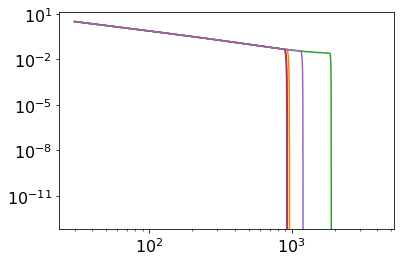

In [209]:
plt.figure()
for amp in all_amp[:5]:
    plt.plot(new_f, amp)
plt.yscale('log')
plt.xscale('log')

In [210]:
np.argmax(np.abs(all_phase[:,-1]))

137

In [211]:
coords[412]

array([124.19550221,   2.98665003,   2.98658353,   2.60000092,
         1.00002226])

In [212]:
cutoff[78]

1013.7290677567017

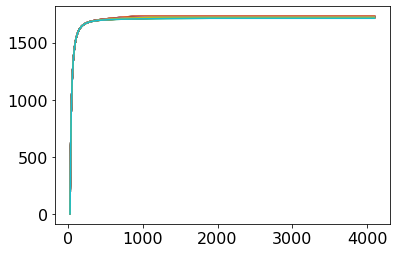

In [213]:
plt.figure()
for phi in all_phase[:50]:
    plt.plot(new_f, phi)
# plt.yscale('log')
# plt.xscale('log')
# plt.xlim(1000, 3000)
# plt.ylim(6000,6200)

In [214]:
int_range = [new_f[0], new_f[-1]]
int_num = len(new_f)
integration = greedyrb.Riemann(int_range, num=int_num)
x = integration.nodes  # Define x for convenience

In [215]:
grb = greedyrb.GreedyReducedBasis(integration=integration)

In [216]:
seed_ts_coords = lambda1s[:1].reshape(1,-1)
seed_ts = all_phase[0].reshape(1,-1)
ts_coords = lambda1s[1:]
ts = all_phase[1:]

In [131]:
seed_ts_coords.shape

(1, 1)

In [132]:
seed_ts_coords

array([[0.]])

In [471]:
seed_ts.shape

(1, 1000)

In [472]:
ts.shape

(499, 1000)

In [473]:
seed_ts.shape

(1, 1000)

In [474]:
seed_ts_coords.shape

(1, 1)

In [475]:
grb.build_seed_basis(ts=seed_ts, ts_coords=seed_ts_coords)

In [476]:
grb.greedy_sweep(ts, ts_coords, verbose=True, greedy_tol=1e-6)

step = 0, error = 222866.88883652075
step = 1, error = 8460.933559039266
step = 2, error = 1351.7037166965474
step = 3, error = 1113.6411324879957
step = 4, error = 157.11457099675698
step = 5, error = 131.24537754661947
step = 6, error = 128.25291522421506
step = 7, error = 80.53841087082574
step = 8, error = 20.891179998393714
step = 9, error = 17.710801191104206
step = 10, error = 17.38586511699103
step = 11, error = 15.003775525092268
step = 12, error = 13.591184187301685
step = 13, error = 13.172894358383287
step = 14, error = 7.570985625887392
step = 15, error = 6.154512800303826
step = 16, error = 3.100693439637255
step = 17, error = 2.4136539839605984
step = 18, error = 2.397390452875501
step = 19, error = 2.2914089356664102
step = 20, error = 2.100592304566849
step = 21, error = 1.917436069423656
step = 22, error = 1.8217733314549194
step = 23, error = 1.813531857778825
step = 24, error = 1.798369783698078
step = 25, error = 1.629302077652372
step = 26, error = 1.5434233279934

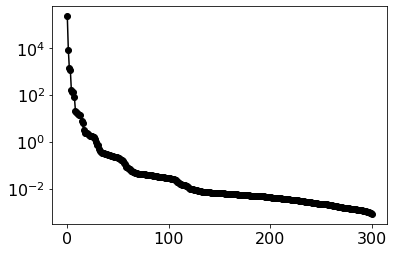

In [477]:
plt.figure()
plt.plot(grb.greedy_errors, 'k-o')
plt.yscale('log')

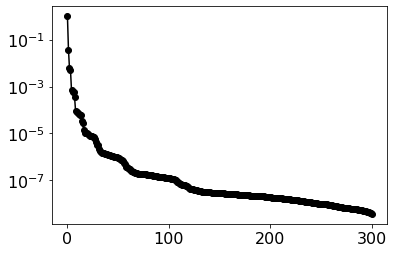

In [478]:
plt.figure()
plt.plot(grb.greedy_errors/grb.greedy_errors[0], 'k-o')
plt.yscale('log')

In [479]:
grb.nbasis

302

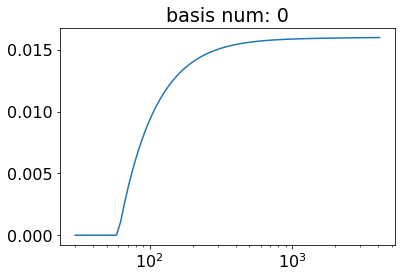

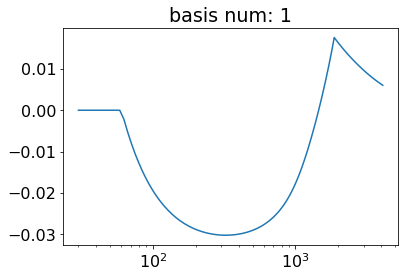

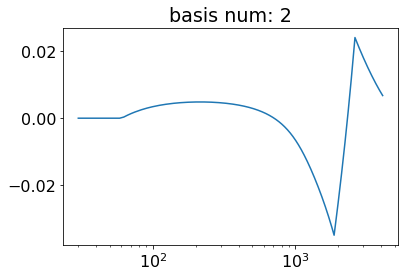

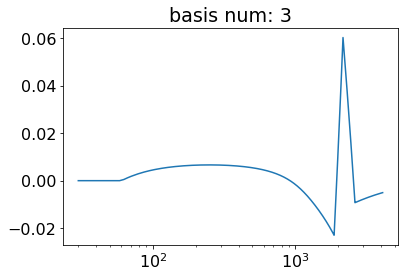

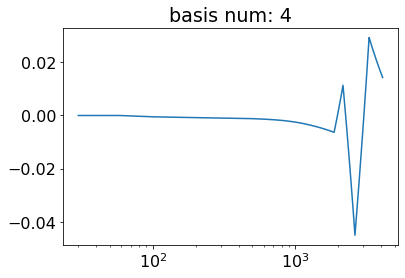

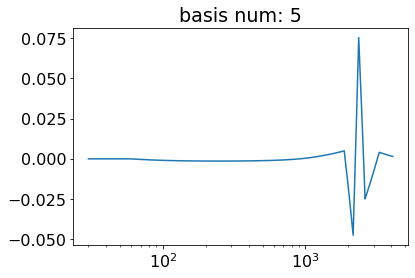

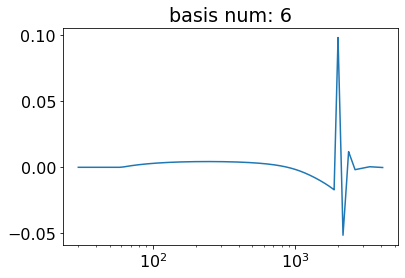

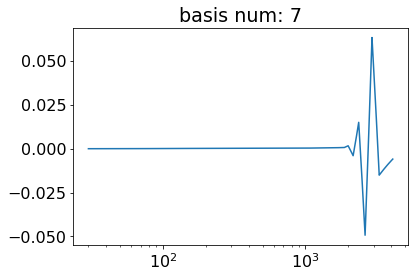

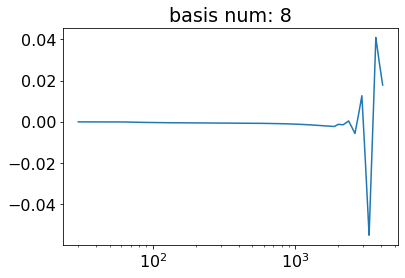

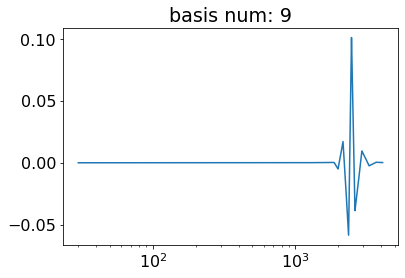

In [480]:
# for i in range(grb.nbasis):
for i in range(10):
    plt.figure()
    plt.plot(x, grb.basis[i])
    plt.title(f"basis num: {i}")
    plt.xscale('log')
    plt.show()
    plt.close()

In [486]:
grb.setup_eim()

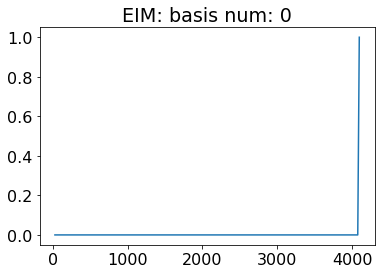

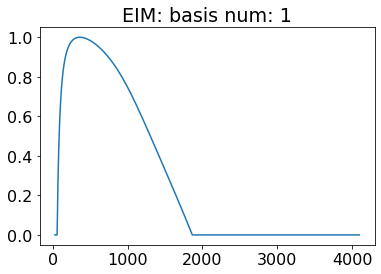

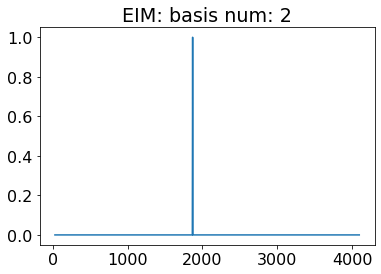

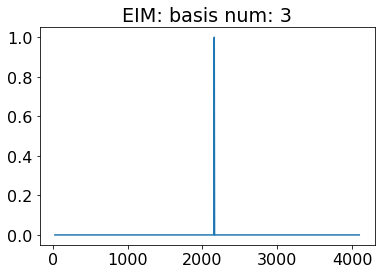

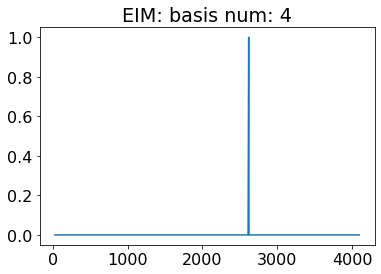

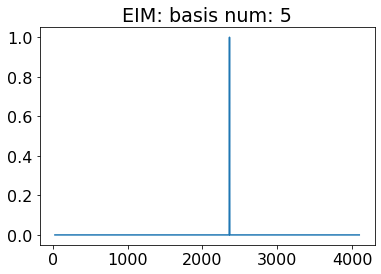

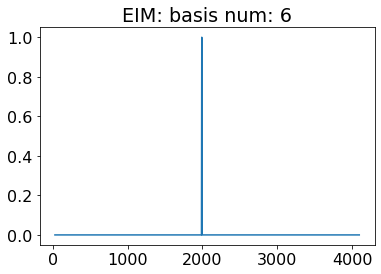

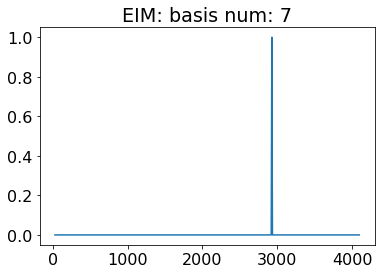

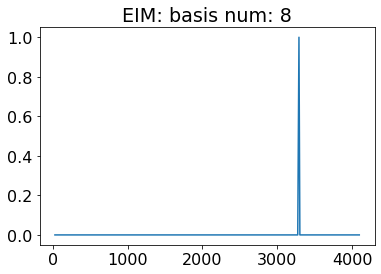

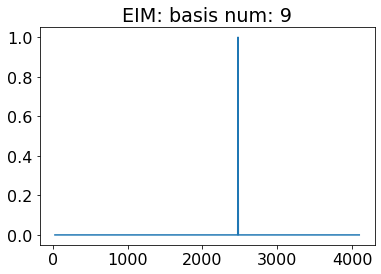

In [487]:
# for i in range(grb.nbasis):
for i in range(10):
    plt.figure()
    plt.plot(x, grb.eim.B[i])
    plt.title(f"EIM: basis num: {i}")
    plt.show()
    plt.close()

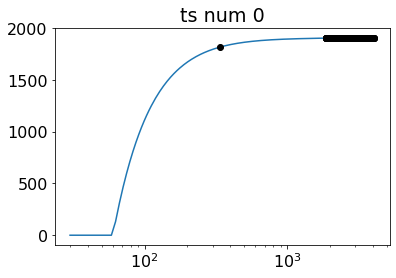

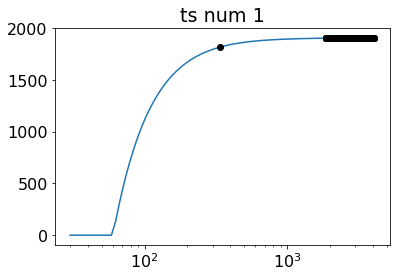

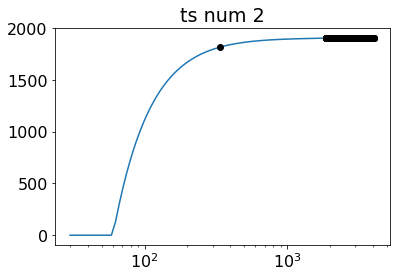

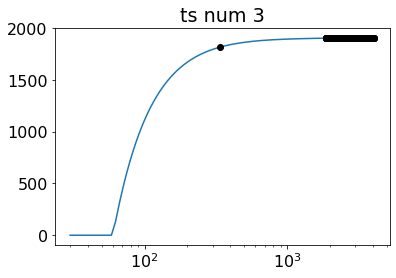

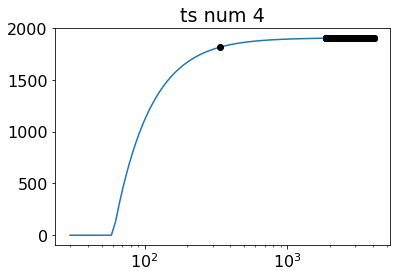

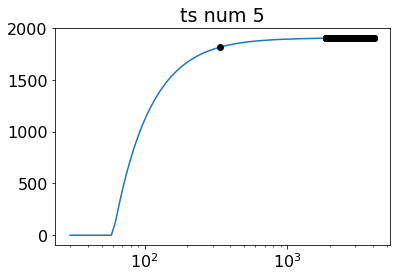

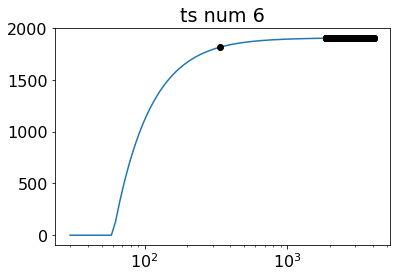

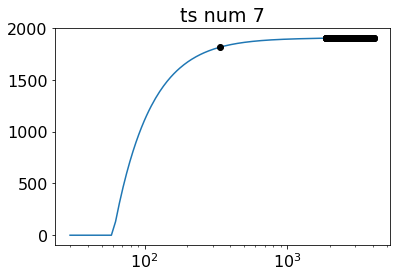

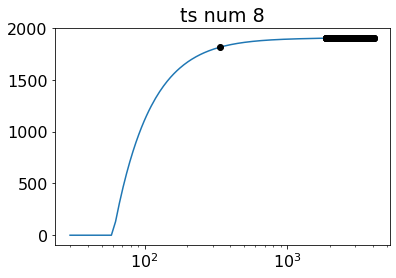

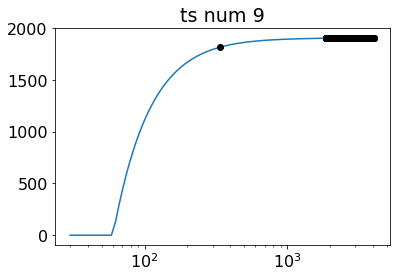

In [488]:
for i in range(ts[:10].shape[0]):
    plt.figure()
    plt.plot(x, ts[i])
    plt.plot(x[grb.eim.indices], ts[i][grb.eim.indices], 'ko')
    plt.title(f"ts num {i}")
    plt.xscale('log')
    plt.show()
    plt.close()

# compare with rompy

In [37]:
import rompy as rp

In [431]:
integration = rp.Integration(int_range, num=int_num, rule='trapezoidal')
x = integration.nodes  # Define x for convenience

In [432]:
rb = rp.ReducedBasis(integration)

In [433]:
rb.make(all_phase, 0, 1e-6, verbose=True)
# rb.make(all_amp, 0, 1e-6, verbose=True)

('\nStep', '\t', 'Error')
(1, '\t', 11960291313.335371)
(2, '\t', 104236.58870506287)
(3, '\t', 4265.647033691406)
(4, '\t', 816.1179828643799)
(5, '\t', 489.78100776672363)
(6, '\t', 93.67727470397949)
(7, '\t', 80.45781326293945)
(8, '\t', 56.03177070617676)
(9, '\t', 21.602373123168945)
(10, '\t', 12.850048065185547)
(11, '\t', 10.23280143737793)
(12, '\t', 10.049591064453125)
(13, '\t', 7.388574600219727)
(14, '\t', 7.349435806274414)
(15, '\t', 5.833982467651367)
(16, '\t', 1.829935073852539)
(17, '\t', 1.7556629180908203)
(18, '\t', 1.6733112335205078)
(19, '\t', 1.4079437255859375)
(20, '\t', 1.2964191436767578)
(21, '\t', 1.249176025390625)
(22, '\t', 1.2240657806396484)
(23, '\t', 1.04779052734375)
(24, '\t', 0.9939422607421875)
(25, '\t', 0.9716129302978516)
(26, '\t', 0.9679698944091797)
(27, '\t', 0.82891845703125)
(28, '\t', 0.7737579345703125)
(29, '\t', 0.6375999450683594)
(30, '\t', 0.32119178771972656)
(31, '\t', 0.3075065612792969)
(32, '\t', 0.300323486328125)
(33, '

In [434]:
rb.size

202

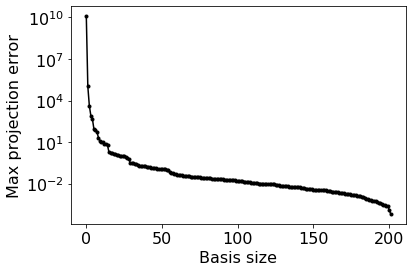

In [435]:
plt.semilogy(rb.errors, 'k.-');
plt.xlabel('Basis size')
plt.ylabel('Max projection error')
plt.show()

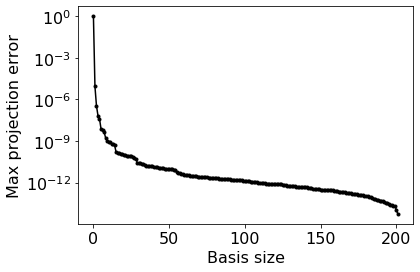

In [436]:
plt.semilogy(rb.errors/rb.errors[0], 'k.-');
plt.xlabel('Basis size')
plt.ylabel('Max projection error')
plt.show()

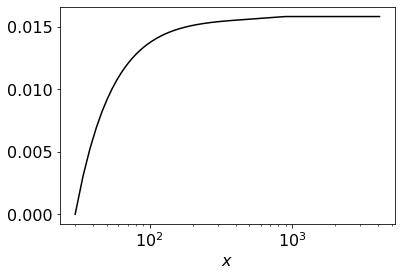

In [437]:
plt.plot(x, rb.basis[0], 'k-')
plt.xlabel('$x$');
plt.xscale('log')
plt.show()

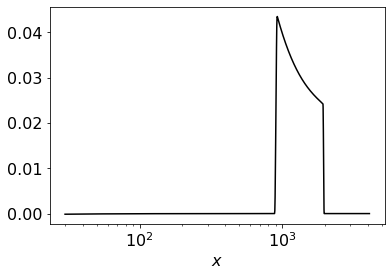

In [299]:
plt.plot(x, rb.basis[1], 'k-')
plt.xlabel('$x$');
plt.xscale('log')
plt.show()

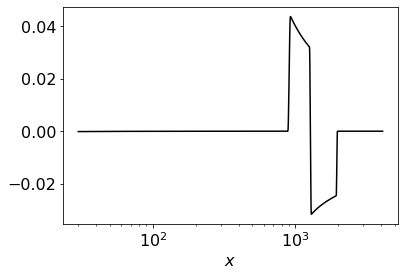

In [300]:
plt.plot(x, rb.basis[2], 'k-')
plt.xlabel('$x$');
plt.xscale('log')
plt.show()

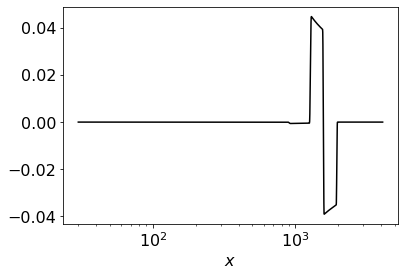

In [301]:
plt.plot(x, rb.basis[3], 'k-')
plt.xlabel('$x$');
plt.xscale('log')
plt.show()

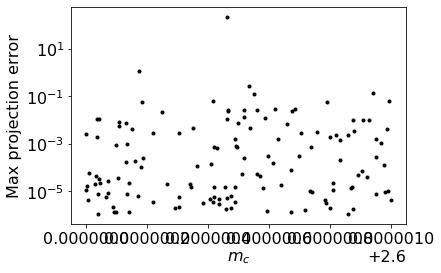

In [302]:
plt.semilogy(mcs[rb.indices], rb.errors, 'k.')
plt.xlabel(r'$m_c$');
plt.ylabel('Max projection error')
# plt.xlim(0, 100);
plt.show()

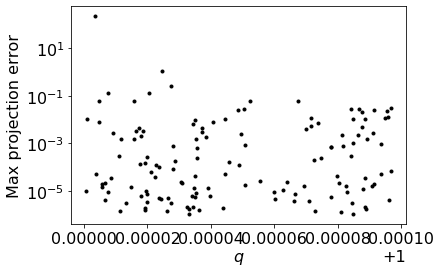

In [303]:
plt.semilogy(qs[rb.indices], rb.errors, 'k.')
plt.xlabel(r'$q$');
plt.ylabel('Max projection error')
# plt.xlim(0, 100);
plt.show()

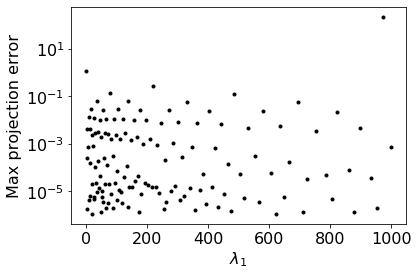

In [304]:
plt.semilogy(l1s[rb.indices], rb.errors, 'k.')
plt.xlabel(r'$\lambda_1$');
plt.ylabel('Max projection error')
# plt.xlim(0, 100);
plt.show()

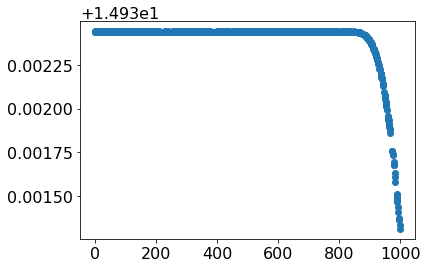

In [306]:
plt.figure()
plt.plot(l1s, rb.alpha[0], 'o')

In [307]:
# # for i in range(rb.alpha.shape[0]):
# for i in range(10):
#     plt.figure()
#     plt.plot(l1s, rb.alpha[i], '-o')
#     plt.title(f"rb index: {i}")
#     plt.show()
#     plt.close()

In [438]:
rb.basis.shape

(202, 1000)

In [439]:
rb.alpha.shape

(202, 1000)

In [440]:
rb_z = np.dot(rb.alpha.T[0], rb.basis)

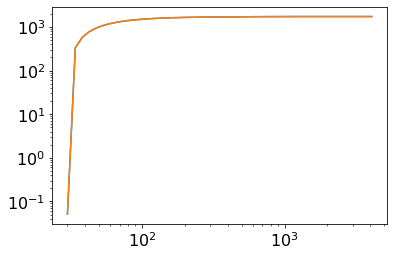

In [441]:
plt.figure()
# plt.plot(x, all_amp[0])
plt.plot(x, all_phase[0])
plt.plot(x, rb_z)
plt.yscale('log')
plt.xscale('log')

In [442]:
eim = rp.EmpiricalInterpolant(rb.basis, verbose=True)

('\nStep', '\t', 'Nodes')
(1, '\t', 209)
(2, '\t', 36)
(3, '\t', 307)
(4, '\t', 246)
(5, '\t', 389)
(6, '\t', 274)
(7, '\t', 224)
(8, '\t', 344)
(9, '\t', 428)
(10, '\t', 259)
(11, '\t', 234)
(12, '\t', 290)
(13, '\t', 216)
(14, '\t', 325)
(15, '\t', 366)
(16, '\t', 410)
(17, '\t', 266)
(18, '\t', 240)
(19, '\t', 282)
(20, '\t', 252)
(21, '\t', 229)
(22, '\t', 299)
(23, '\t', 316)
(24, '\t', 212)
(25, '\t', 448)
(26, '\t', 355)
(27, '\t', 220)
(28, '\t', 334)
(29, '\t', 378)
(30, '\t', 208)
(31, '\t', 399)
(32, '\t', 237)
(33, '\t', 255)
(34, '\t', 270)
(35, '\t', 295)
(36, '\t', 278)
(37, '\t', 243)
(38, '\t', 227)
(39, '\t', 262)
(40, '\t', 214)
(41, '\t', 249)
(42, '\t', 286)
(43, '\t', 311)
(44, '\t', 231)
(45, '\t', 349)
(46, '\t', 218)
(47, '\t', 419)
(48, '\t', 321)
(49, '\t', 222)
(50, '\t', 372)
(51, '\t', 339)
(52, '\t', 303)
(53, '\t', 438)
(54, '\t', 330)
(55, '\t', 361)
(56, '\t', 211)
(57, '\t', 384)
(58, '\t', 226)
(59, '\t', 456)
(60, '\t', 257)
(61, '\t', 210)
(62, '\t

In [443]:
eim.make_data(all_phase)

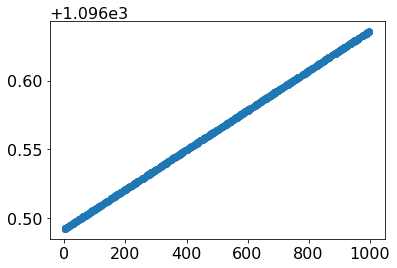

In [444]:
plt.figure()
plt.plot(l1s, eim.data[-1], 'o')

<Figure size 432x288 with 0 Axes>

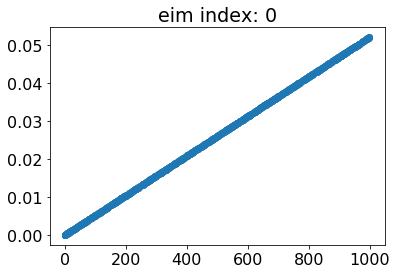

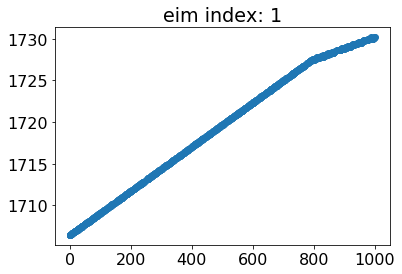

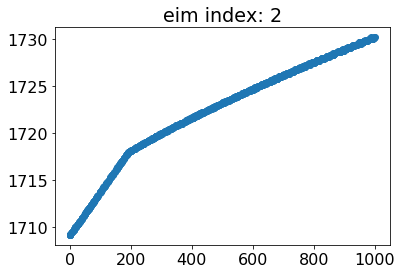

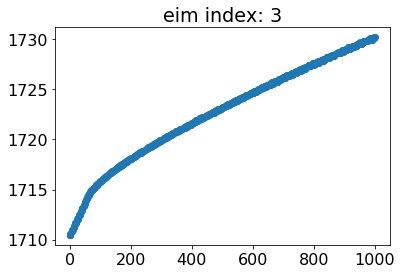

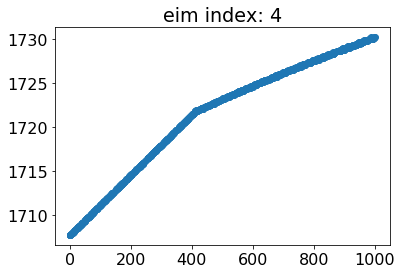

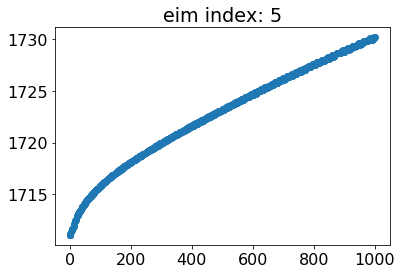

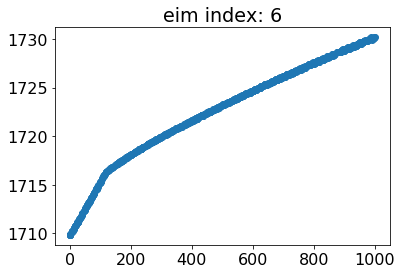

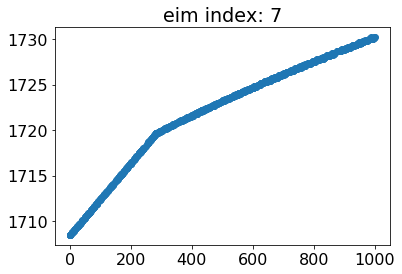

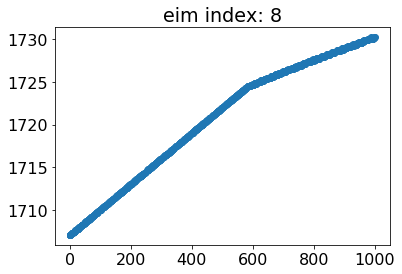

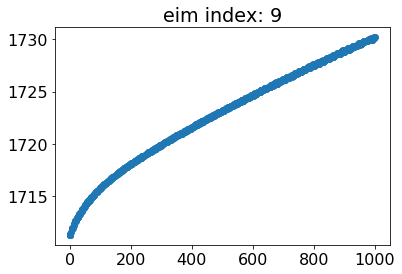

In [311]:
plt.figure()
# for i in range(eim.data.shape[0]):
for i in range(10):
    plt.figure()
    plt.plot(l1s, eim.data[i], 'o')
    plt.title(f"eim index: {i}")
    plt.show()
    plt.close()

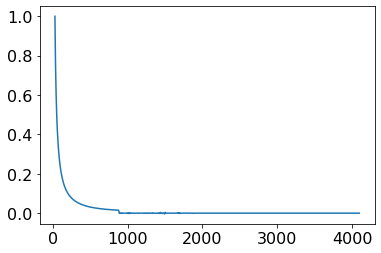

In [374]:
plt.figure()
plt.plot(x, eim.B[0])

In [313]:
eim.B[0];

# fits

In [314]:
import numpy as np
import tensorflow as tf
import datetime
from sklearn.model_selection import train_test_split

In [315]:
class PrintDot(tf.keras.callbacks.Callback):
    """
    Display training progress by printing a single dot for
    each completed epoch.
    """

    def on_epoch_end(self, epoch, logs) -> None:
        """
        `on_epoc_end` hook to take the epoch number and logs.
        This will run whenever the training loop finishes an epoch.
        """
        if epoch % 100 == 0:
            print("")
        print(".", end="")

In [316]:
import scrinet.fits.scale

In [445]:
# extract lambda1, chirp_mass and mass_ratio
X = coords[:,[0,3,4]].copy()
# y = eim.data.T.copy()

# y = y[:, :10]



y = rb.alpha.T.copy()

In [446]:
X.shape

(1000, 3)

In [447]:
y.shape

(1000, 202)

In [448]:
X_scalers = scrinet.fits.scale.make_scalers(X)
y_scalers = scrinet.fits.scale.make_scalers(y)

In [449]:
X_scaled = scrinet.fits.scale.apply_scaler(X, X_scalers)
y_scaled = scrinet.fits.scale.apply_scaler(y, y_scalers)

In [450]:
y_scaled.shape

(1000, 202)

In [451]:
def build_model(units=16, n_hidden_layers=2, activation='relu', batch_norm=False, input_dim=1, n_output=1):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units, input_dim=input_dim, activation=activation))
    if batch_norm:
        model.add(tf.keras.layers.BatchNormalization())
    for i in range(n_hidden_layers):
        model.add(tf.keras.layers.Dense(units, activation=activation))
        if batch_norm:
            model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(n_output, activation='linear'))
    model.summary()
    return model

In [452]:
def compile_model(model, learning_rate=1e-3, optimizer=tf.keras.optimizers.Adam):
    opt = optimizer(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=opt, metrics=['mse'])
    
    return model

In [453]:
model = build_model(units=256, n_hidden_layers=2, activation='relu', input_dim=X_scaled.shape[1], n_output=y_scaled.shape[1])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 256)               1024      
_________________________________________________________________
dense_29 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_30 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_31 (Dense)             (None, 202)               51914     
Total params: 184,522
Trainable params: 184,522
Non-trainable params: 0
_________________________________________________________________


In [454]:
model = compile_model(model, learning_rate=1e-3, optimizer=tf.keras.optimizers.Adam)

In [455]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5, verbose=1, mode='min')
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,verbose=2, mode='auto')

In [456]:
# callbacks = [PrintDot(), reduce_lr, es]
callbacks = [PrintDot(), reduce_lr]
# callbacks = [PrintDot()]

In [457]:
X_scaled.shape

(1000, 3)

In [458]:
y_scaled.shape

(1000, 202)

In [459]:
starttime = datetime.datetime.now()
history = model.fit(
    X_scaled,
    y_scaled,
    epochs=500,
    batch_size=128,
    verbose=0,
    callbacks=callbacks,
    validation_split=0.3
)
endtime = datetime.datetime.now()

print('\nThe time cost: ')
print(endtime - starttime)


............................................
Epoch 00044: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
..........
Epoch 00054: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
..........
Epoch 00064: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
..........
Epoch 00074: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
..........
Epoch 00084: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
..........
Epoch 00094: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
......
....
Epoch 00104: ReduceLROnPlateau reducing learning rate to 1e-05.
................................................................................................
....................................................................................................
....................................................................................................
............................................

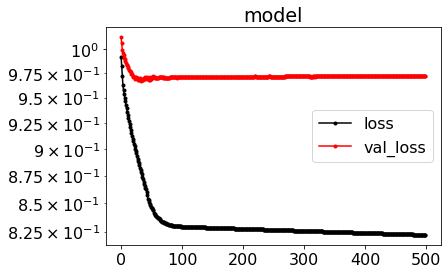

In [460]:
plt.figure()
plt.plot(history.history['loss'], 'k.-', label='loss')
plt.plot(history.history['val_loss'], 'r.-', label='val_loss')
plt.yscale('log')
plt.title('model')
plt.legend()

In [461]:
yhat_scaled = model.predict(X_scaled)

In [462]:
yhat_scaled.shape

(1000, 202)

In [463]:
y_scaled.shape

(1000, 202)

In [464]:
X_scaled.shape

(1000, 3)

In [465]:
y_scaled.shape

(1000, 202)

(-0.1, 0.1)

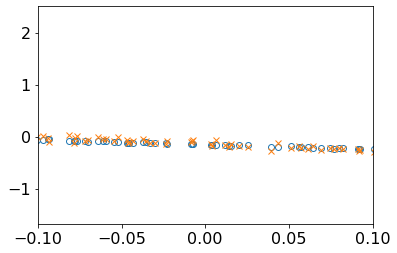

In [466]:
plt.figure()
plt.plot(X_scaled[:,0], y_scaled[:,1], 'o', markerfacecolor="None")
plt.plot(X_scaled[:,0], yhat_scaled[:,1], 'x')
plt.xlim(-0.1,0.1)

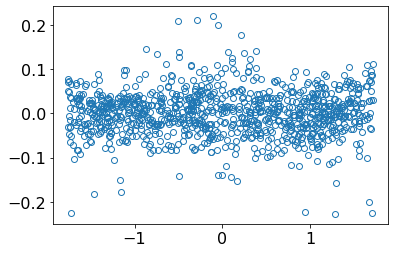

In [467]:
plt.figure()
plt.plot(X_scaled[:,1], y_scaled[:,0]-yhat_scaled[:,0], 'o', markerfacecolor="None")
# plt.plot(X_scaled[:,0], yhat_scaled[:,0], 'x')
# plt.xlim(-0.1,0.1)

In [468]:
yhat = scrinet.fits.scale.apply_inverse_scaler(yhat_scaled, y_scalers)

(0, 100)

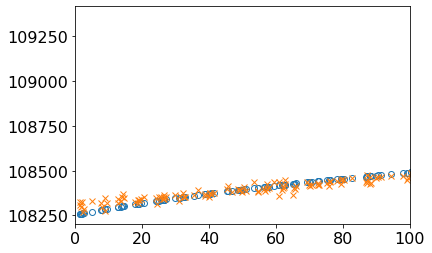

In [469]:
plt.figure()
plt.plot(X[:,0], y[:,0], 'o', markerfacecolor="None")
plt.plot(X[:,0], yhat[:,0], 'x')
plt.xlim(0,100)

In [470]:
eim.B.shape

(202, 1000)

In [471]:
yhat.shape

(1000, 202)

In [472]:
y.shape

(1000, 202)

In [473]:
rb.basis.shape

(202, 1000)

In [474]:
y.shape

(1000, 202)

In [475]:
eim.B.shape

(202, 1000)

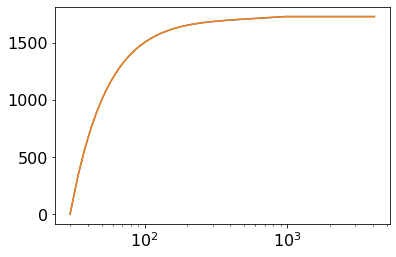

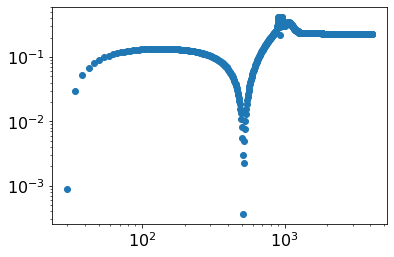

In [483]:
idx = 30

# z = np.dot(y[idx], rb.basis)
z = np.dot(yhat[idx], rb.basis)

# z = np.dot(y[idx], eim.B)
# z = np.dot(yhat[idx], eim.B)

plt.figure()
# plt.plot(x, all_amp[idx])
plt.plot(x, all_phase[idx])
plt.plot(x, z)
plt.xscale('log')
# plt.yscale('log')
# plt.xlim(10, 2000)
# plt.ylim(1500, 2000)

plt.figure()
# plt.plot(x, np.abs(all_amp[idx]-z), 'o')
plt.plot(x, np.abs(all_phase[idx]-z), 'o')
plt.xscale('log')
plt.yscale('log')
